In [1]:
import numpy
import numpy as np
import pandas
import pandas as pd
from numba import njit
import sys,glob
import zipfile, os, time
import urllib3
from datetime import datetime, timedelta
import glob
import h5py
sys.path.append(os.getcwd()+'/../cds-backend/code/')
sys.path.append(os.getcwd()+'/../harvest/code/')
sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
import rasotools
from harvest_convert_to_netCDF_newfixes import write_dict_h5
import cds_eua3 as eua
eua.logging_set_level(30)
import xarray as xr

import cdsapi, zipfile, os, time
#import schedule
import copy
from shutil import copyfile
import multiprocessing
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import warnings
warnings.filterwarnings('ignore')



In [2]:
@njit        
def tcost(dists, slopes, cost):
    # calculate trend heterogeneity cost function

    id = 0
    goodstats = 0
    tcost = 0.
    for l in range(slopes.shape[0]):
        cost[l] = 0.
    for l in range(slopes.shape[0]):
        if slopes[l] == slopes[l]:
            goodstats += 1
            for k in range(l, slopes.shape[0]):
                if slopes[l] == slopes[l] and slopes[k] == slopes[k]:
                    s = (slopes[l]-slopes[k])*dists[id]
                    cost[l] += s*s
                    cost[k] += s*s
                    if l == 24 and k == 29:
                        print((dists[id], slopes[l], slopes[k]))
                id += 1
            if goodstats > 0:
                tcost += cost[l]
        else:
            id += slopes.shape[0]-l

    if goodstats > 0:
        tcost /= goodstats
        for l in range(slopes.shape[0]):
            cost[l] /= goodstats

    return tcost

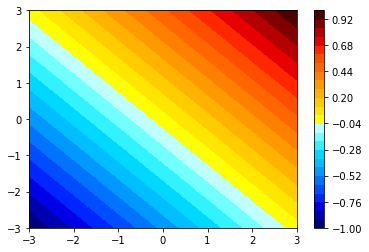

ready


In [3]:
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy

def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=numpy.float))

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    se = [(None,) * 3, 0.0]
    for s in seq:
        se.append(s[0])
        se.append(s[1])#+ list(seq) +
        seq=se+[ (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
"rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
"rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
"rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
"rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
"rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
"rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
"rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
"rgb(0.7,0,0)", "rgb(0.5,0,0)", "rgb(0.3,0,0)"]
rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))

cmnew=make_colormap(rgblist2)

x,y=numpy.meshgrid(numpy.linspace(-3,3,101),numpy.linspace(-3,3,101))
gauss=x/6+y/6
clist=numpy.linspace(-1,1,26)
plt.contourf(x,y,gauss,clist,cmap=cmnew)
plt.colorbar()
plt.show()
print('ready')

## plotting function

In [143]:
def plt_trends(i):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (12, 8),
             'axes.labelsize': 'x-large',
             'axes.titlesize': 20,
             'xtick.labelsize':'medium',
             'ytick.labelsize':'medium'}
    pylab.rcParams.update(params)

    igra = pickle.load( open( i, "rb" ))
    i = i.split('/')[-1]
    da = igra.dropna()
    print(da)
    statnum = len(da)
    a = rasotools.plot._helpers.cost(np.asarray(da.location_longitude), np.asarray(da.location_latitude), np.asarray(da.station_name))
    cost = np.sum(a)/len(a)
    
    ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.coastlines()

    reduced = np.asarray(da['station_name'])
    longitudes = list(da['location_longitude'])
    latitudes = list(da['location_latitude'])
    plt.scatter(longitudes, latitudes, s=40, alpha=1,
                c= da['station_name'],
                cmap=cmnew,
                vmin=-2,
                vmax=2,
                edgecolor='k',)
    plt.colorbar(orientation='horizontal', label='Trend', shrink=0.9, pad=0.05)
    plt.tight_layout()
#     plt.title('CUAN'+i.split('.')[0][4:]+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(statnum))
#     plt.savefig('plots/'+'CUAN'+i[4:]+'ng', bbox_inches='tight')
    plt.title(i.split('.')[0]+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(statnum))
    plt.savefig('plots_new/'+i+'ng', bbox_inches='tight')
    plt.close()


# Trends

---

## Requesting CUAN Data

In [4]:
# import numpy
# import numpy as np
# import pandas as pd
# import sys, glob
# import urllib3
# import h5py
# import cdsapi, zipfile, os, time
# sys.path.append(os.getcwd()+'/../cds-backend/code/')
# import cds_eua3 as eua
# import warnings
# import shutil
# import pickle
# warnings.filterwarnings('ignore')

# def request(rqdict, source, remove_file=True):
#     t0 = time.time()

#     c = cdsapi.Client()
#     r = c.retrieve(
#         source,rqdict)
#     if True:
#         r.download(target='download.zip')
#         assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
#     z = zipfile.ZipFile('download.zip')
#     z.extractall(path='./download/')
#     z.close()
#     print('Request took: ' + str(time.time() - t0) + ' seconds')
    
#     files = glob.glob('./download/*.nc')
    
#     if files[0].split('/')[-1].startswith('IGRA'):
#         ds = xarray.open_dataset(files[0])            
#         data = ds.to_dataframe()
#         for i in files[1:]:
#             ds = xarray.open_dataset(i)            
#             data = data.append(ds.to_dataframe())

#     else:
#         data=eua.CDMDataset(files[0]).to_dataframe()
#         for i in files[1:]:
#             da = eua.CDMDataset(i).to_dataframe()
#             data = data.append(da)
            
#     os.remove('download.zip')
#     if remove_file:
#         try:
#            shutil.rmtree('./download/')
#         except:
#            print('Error while deleting directory')

#     return data

# stations = pickle.load( open( "stations.p", "rb" ))
# for i in stations.station_name:
#     if not '/raid60/scratch/uli/IGRA_Data/COMP/COMP_'+str(i)+'_100.p' in glob.glob('/raid60/scratch/uli/IGRA_Data/COMP/*'):
#         try:
#             data = request({'variable':['temperature'],
#                             'statid': i[-5:],
#                             'period': '1979-01-01/2019-12-31',
#                             'optional':'bias_estimate',
#                             'pressure_level': 100,
#                            }, 'insitu-comprehensive-upper-air-observation-network',
#             )
#         except:
#             pass
#         pickle.dump( data, open( '/raid60/scratch/uli/IGRA_Data/COMP/COMP_' + str(i) + '_100.p', "wb" ))
#     else:
#         print('-')

In [4]:
stations = pickle.load( open( "stations.p", "rb" ))
stations

,station_name,location_longitude,location_latitude
0,KRM00091487,-159.3670,3.8500
1,CHM00055664,87.0830,28.6330
2,CHM00056444,98.8830,28.4500
3,BMM00048062,92.8830,20.1330
4,CHM00057290,114.0500,32.9670
...,...,...,...
36592,INM00043110,73.3333,16.9833
37459,INM00042165,73.3000,28.0000
37460,INM00042328,70.9167,26.9000
37461,RPM00098233,121.7525,17.6375


## Creating Trendfiles from CUAN

old version

In [20]:
# stations = pickle.load( open( "stations.p", "rb" ))
# sout = []
# start = 1979
# end = 2000
# intervall = end - start
# for i in range(len(stations.station_name)):
#     files = glob.glob('/raid60/scratch/uli/IGRA_Data/COMP/COMP_' + str(stations.station_name.iloc[i]) + '*.p')
#     if len(files) > 0:
#         temp = pickle.load( open( files[0], "rb" ))
#         temp = temp[temp.plev == 10000]
#         temp = temp[temp.time > '1979-01-01 00:00:00'][temp.time < '2001-01-01 00:00:00']
#         temp.sort_values('time')
#         temptime = temp.time
# #         temp['month'] = temptime.dt.month
# #         monthlymeans = temp.groupby(['month'],as_index=False).mean('time')
# #         if len(monthlymeans) > 0:
# #             out = temp[temp.month == monthlymeans.iloc[0].month].ta - np.array([monthlymeans.iloc[0].ta]*len(temp[temp.month == monthlymeans.iloc[0].month].ta))
# #             for i in range(len(monthlymeans)):
# #                 out = out.append(temp[temp.month == monthlymeans.iloc[i].month].ta - np.array([monthlymeans.iloc[i].ta]*len(temp[temp.month == monthlymeans.iloc[i].month].ta)))
# #             out = out.reset_index(drop=True)
#         out = temp.ta
#         temp = out[out < out.quantile(q = 0.999)][out > out.quantile(q = 0.001)]
#         if len(temp) >= 19*365 and len(numpy.unique(temptime.dt.year)) > 19 :
#             selected = np.asarray(temp)[~np.isnan(np.asarray(temp))]
#             datlen = len(selected)
#             try:
#                 coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
# #                     station.station_name.iloc[i] = coefficients[0]*(10/intervall*len(temp))
#                 sout.append(coefficients[0]*(10/intervall*len(temp)))
# #                     print(sout.station_name.iloc[i])
#             except:
# #                     station.station_name.iloc[i] = np.nan
#                 sout.append(np.nan)
#         else:
# #                 sout.station_name.iloc[i] = np.nan
#             sout.append(np.nan)
# #         else: sout.append(np.nan) # sout.station_name.iloc[i] = np.nan
#     else: sout.append(np.nan) # sout.station_name.iloc[i] = np.nan
# stations.station_name = sout
# pickle.dump( stations, open( "new_CUON_100hPa_1979_2000_Trend.p", "wb" ))

---

actual version

In [142]:
stations = pickle.load( open( "stations.p", "rb" ))
sout = []
start = 1979
end = 2000
intervall = end - start
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/COMP/COMP_' + str(stations.station_name.iloc[i]) + '*.p')
#     print(files)
    if len(files) > 0:
        temp = pickle.load( open( files[0], "rb" ))
        temp = temp[temp.plev == 10000]
        temp = temp[temp.time > '1979-01-01 00:00:00'][temp.time < '2001-01-01 00:00:00']
        if len(temp) > 0:
            temp.sort_values('time')
            temp.time = pd.to_datetime(temp['time'])
            temp.lat = numpy.array([temp.lat.iloc[0]]*len(temp))
            temp.lon = numpy.array([temp.lon.iloc[0]]*len(temp))
            temptime = temp.time
            if len(temp) >= 19*365 and len(numpy.unique(temptime.dt.year)) > 19 :
                xa = temp.set_index(['lat', 'lon', 'time']).to_xarray()
                out = rasotools.met.time.trend(xa.ta,only_slopes=True).to_dataframe(name='out')
                sout.append(float(out.iloc[-1] *3650))
            else:
                sout.append(np.nan)
        else: sout.append(np.nan) 
    else: sout.append(np.nan) 
stations.station_name = sout
pickle.dump( stations, open( "new_CUON_100hPa_1979_2000_Trend.p", "wb" ))

In [ ]:
stations = pickle.load( open( "stations.p", "rb" ))
sout = []
start = 2000
end = 2019
intervall = end - start
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/COMP/COMP_' + str(stations.station_name.iloc[i]) + '*.p')
#     print(files)
    if len(files) > 0:
        temp = pickle.load( open( files[0], "rb" ))
        temp = temp[temp.plev == 10000]
        temp = temp[temp.time > '2000-01-01 00:00:00'][temp.time < '2020-01-01 00:00:00']
        if len(temp) > 0:
            temp.sort_values('time')
            temp.time = pd.to_datetime(temp['time'])
            temp.lat = numpy.array([temp.lat.iloc[0]]*len(temp))
            temp.lon = numpy.array([temp.lon.iloc[0]]*len(temp))
            temptime = temp.time
            if len(temp) >= 17*365 and len(numpy.unique(temptime.dt.year)) > 17 :
                xa = temp.set_index(['lat', 'lon', 'time']).to_xarray()
                out = rasotools.met.time.trend(xa.ta,only_slopes=True).to_dataframe(name='out')
                sout.append(float(out.iloc[-1] *3650))
            else:
                sout.append(np.nan)
        else: sout.append(np.nan) 
    else: sout.append(np.nan) 
stations.station_name = sout
pickle.dump( stations, open( "new_CUON_100hPa_2000_2019_Trend.p", "wb" ))

In [ ]:
stations = pickle.load( open( "stations.p", "rb" ))
sout = []
start = 1979
end = 2000
intervall = end - start
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/COMP/COMP_' + str(stations.station_name.iloc[i]) + '*.p')
#     print(files)
    if len(files) > 0:
        temp = pickle.load( open( files[0], "rb" ))
        temp = temp[temp.plev == 10000]
        temp = temp[temp.time > '1979-01-01 00:00:00'][temp.time < '2001-01-01 00:00:00']
        if len(temp) > 0:
            temp.sort_values('time')
            temp.time = pd.to_datetime(temp['time'])
            temp.lat = numpy.array([temp.lat.iloc[0]]*len(temp))
            temp.lon = numpy.array([temp.lon.iloc[0]]*len(temp))
            temptime = temp.time
            if len(temp) >= 19*365 and len(numpy.unique(temptime.dt.year)) > 19 :
                temp.ta = temp.ta - numpy.nan_to_num(temp.bias_estimate)
                xa = temp.set_index(['lat', 'lon', 'time']).to_xarray()
                out = rasotools.met.time.trend(xa.ta,only_slopes=True).to_dataframe(name='out')
                sout.append(float(out.iloc[-1] *3650))
            else:
                sout.append(np.nan)
        else: sout.append(np.nan) 
    else: sout.append(np.nan) 
stations.station_name = sout
pickle.dump( stations, open( "new_CUON_BC_100hPa_1979_2000_Trend.p", "wb" ))

In [ ]:
stations = pickle.load( open( "stations.p", "rb" ))
sout = []
start = 2000
end = 2019
intervall = end - start
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/COMP/COMP_' + str(stations.station_name.iloc[i]) + '*.p')
#     print(files)
    if len(files) > 0:
        temp = pickle.load( open( files[0], "rb" ))
        temp = temp[temp.plev == 10000]
        temp = temp[temp.time > '2000-01-01 00:00:00'][temp.time < '2020-01-01 00:00:00']
        if len(temp) > 0:
            temp.sort_values('time')
            temp.time = pd.to_datetime(temp['time'])
            temp.lat = numpy.array([temp.lat.iloc[0]]*len(temp))
            temp.lon = numpy.array([temp.lon.iloc[0]]*len(temp))
            temptime = temp.time
            if len(temp) >= 17*365 and len(numpy.unique(temptime.dt.year)) > 17:
                temp.ta = temp.ta - numpy.nan_to_num(temp.bias_estimate)
                xa = temp.set_index(['lat', 'lon', 'time']).to_xarray()
                out = rasotools.met.time.trend(xa.ta,only_slopes=True).to_dataframe(name='out')
                sout.append(float(out.iloc[-1] *3650))
            else:
                sout.append(np.nan)
        else: sout.append(np.nan)
    else: sout.append(np.nan)
stations.station_name = sout
pickle.dump( stations, open( "new_CUON_BC_100hPa_2000_2019_Trend.p", "wb" ))

---

In [144]:
trends = glob.glob('new_CUON**Trend.p')
trends

for i in trends:
    plt_trends(i)

       station_name  location_longitude  location_latitude
31        -0.603326            102.7833            46.2667
45        -0.023109             84.8500            45.6000
47         0.000149             86.1330            41.7500
60        -0.468141            121.0670            41.1170
61        -0.468141            116.7167            20.7167
...             ...                 ...                ...
31320     -0.617212             12.5992            46.0303
31321     -0.617212            -11.0000            43.4000
31324     -0.617212            -26.8000            32.6000
31326     -0.730198            133.0656            35.4572
33077     -0.832640              8.9675            39.3461

[602 rows x 3 columns]
       station_name  location_longitude  location_latitude
31         0.351375            102.7833            46.2667
45        -0.208136             84.8500            45.6000
47        -0.316717             86.1330            41.7500
60        -0.482739            1

---

## Splitting IGRA Files into single station year files

In [64]:
# def savetoarray(file, dataset: str='IGRA', dest: str='./temp100/'):
#     yr = file.split('/')[6]
#     print(yr)
#     plev = 50000
#     chunk = pd.read_csv(file, header=12, index_col=False, usecols=['station_name', 'air_temperature', 'air_pressure'])
#     stations = chunk.station_name.drop_duplicates()
#     for i in stations:
#         if not os.path.isfile( dest + dataset + '_' + i + '_' + yr + '_' + str(plev) + ".p"):
#             da = chunk[chunk.station_name == i]
#             da = da[da.air_pressure == plev]
#             pickle.dump( np.asarray(da.air_temperature), open( dest + dataset + '_' + i + '_' + yr + '_' + str(plev) + ".p", "wb" ))

In [4]:
import glob
# a = glob.glob('/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_H_*.p')
b = glob.glob('/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_' + 'KRM00091487' + '*.p')
b

['/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_1979_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_2019_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_2018_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_1980_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_1981_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_1983_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_1984_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_2008_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_2011_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_2015_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_2009_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_2012_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_2016_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_2010_100.p',
 '/raid60/scratch/uli/IGRA_Data/IGRA/IGRA_KRM00091487_2013_100

In [33]:
b[0].split('_')[-2]

'1979'

In [65]:
savetoarray(glob.glob('/raid60/scratch/uli/IGRA_Data/IGRA/2019/*')[0])

2019


## Creating Trendfiles from IGRA and IGRA_H

In [61]:
stations = pickle.load( open( "stations.p", "rb" ))
sout = []
start = 1979
end = 2000
intervall = end - start
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/IGRA/*' + stations.station_name.iloc[i] + '*.p')
    if len(files) > 0:
        filesinintervall = []
        for o in files:
            yr = int(o.split('_')[-2])
            if yr <= end and yr >= start:
                filesinintervall.append(o)
        temp = pickle.load( open( filesinintervall[0], "rb" ))
        for j in filesinintervall[1:]:
            temp = temp.append(pickle.load( open( j, "rb" )))
        if len(temp) > 0:
            temp = temp.drop(['air_pressure', 'report_id', 'observed_variable', 'station_name'], axis = 1)
            temp = temp.rename(columns={'report_timestamp': 'time'})
            temp = temp.sort_values('time')
            temp.time = pd.to_datetime(temp['time'])
            temp.time = pd.DatetimeIndex(temp['time'].values)
            temptime = temp.time
            if len(temp) >= 19*365 and len(numpy.unique(temptime.dt.year)) > 19 :
                xa = temp.set_index(['location_latitude', 'location_longitude', 'time']).to_xarray()
                out = rasotools.met.time.trend(xa.observed_value, only_slopes=True).to_dataframe(name='out')
                sout.append(float(out.iloc[-1] *3650))
            else:
                sout.append(np.nan)
        else:
            sout.append(np.nan)
    else:
        sout.append(np.nan)

stations.station_name = sout
pickle.dump( stations, open( "IGRA_100hPa_1979_2000_Trend.p", "wb" ))


[nan]
[nan, nan]
[nan, nan, nan]
[nan, nan, nan, nan]
[nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, 

KeyboardInterrupt: 

In [ ]:
stations = pickle.load( open( "stations.p", "rb" ))
sout = []
start = 1979
end = 2000
intervall = end - start
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/IGRA_H/*' + stations.station_name.iloc[i] + '*.p')
    if len(files) > 0:
        filesinintervall = []
        for o in files:
            yr = int(o.split('_')[-2])
            if yr <= end and yr >= start:
                filesinintervall.append(o)
        temp = pickle.load( open( filesinintervall[0], "rb" ))
        for j in filesinintervall[1:]:
            temp = temp.append(pickle.load( open( j, "rb" )))
        if len(temp) > 0:
            temp = temp.drop(['air_pressure', 'report_id', 'observed_variable', 'station_name'], axis = 1)
            temp = temp.rename(columns={'report_timestamp': 'time'})
            temp = temp.sort_values('time')
            temp.time = pd.to_datetime(temp['time'])
            temp.time = pd.DatetimeIndex(temp['time'].values)
            temptime = temp.time
            if len(temp) >= 19*365 and len(numpy.unique(temptime.dt.year)) > 19 :
                xa = temp.set_index(['location_latitude', 'location_longitude', 'time']).to_xarray()
                out = rasotools.met.time.trend(xa.observed_value, only_slopes=True).to_dataframe(name='out')
                sout.append(float(out.iloc[-1] *3650))
            else:
                sout.append(np.nan)
        else:
            sout.append(np.nan)
    else:
        sout.append(np.nan)

stations.station_name = sout
pickle.dump( stations, open( "IGRA_H_100hPa_1979_2000_Trend.p", "wb" ))


In [78]:
stations = pickle.load( open( "stations.p", "rb" ))
sout = []
start = 2000
end = 2019
intervall = end - start
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/IGRA/*' + stations.station_name.iloc[i] + '*.p')
    if len(files) >= 17:
        filesinintervall = []
        for o in files:
            yr = int(o.split('_')[-2])
            if yr <= end and yr >= start:
                filesinintervall.append(o)
        temp = pickle.load( open( filesinintervall[0], "rb" ))
        if 'air_temperature' in temp:
            temp = temp.rename(columns={'air_temperature': 'observed_value'})
        for j in filesinintervall[1:]:
            add = pickle.load( open( j, "rb" ))
            if 'air_temperature' in add:
                add = add.rename(columns={'air_temperature': 'observed_value'})
            temp = temp.append(add)
        if len(temp) > 0:
            temp = temp.drop(['air_pressure', 'report_id', 'observed_variable', 'station_name'], axis = 1)
            temp = temp.rename(columns={'report_timestamp': 'time'})
            temp = temp.sort_values('time')
            temp.time = pd.to_datetime(temp['time'])
            temp.time = pd.DatetimeIndex(temp['time'].values)
            temptime = temp.time
            temp.location_latitude = numpy.array([temp.location_latitude.iloc[0]]*len(temp))
            temp.location_longitude = numpy.array([temp.location_longitude.iloc[0]]*len(temp))
            if len(temp) >= 17*365 and len(numpy.unique(temptime.dt.year)) > 17:
                xa = temp.set_index(['location_latitude', 'location_longitude', 'time']).to_xarray()
                out = rasotools.met.time.trend(xa.observed_value, only_slopes=True).to_dataframe(name='out')
                sout.append(float(out.iloc[-1] *3650))
            else:
                sout.append(np.nan)
        else:
            sout.append(np.nan)
    else:
        sout.append(np.nan)
stations.station_name = sout
pickle.dump( stations, open( "IGRA_100hPa_2000_2019_Trend.p", "wb" ))


In [ ]:
stations = pickle.load( open( "stations.p", "rb" ))
sout = []
start = 2000
end = 2019
intervall = end - start
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/IGRA_H/*' + stations.station_name.iloc[i] + '*.p')
    if len(files) >= 17:
        filesinintervall = []
        for o in files:
            yr = int(o.split('_')[-2])
            if yr <= end and yr >= start:
                filesinintervall.append(o)
        temp = pickle.load( open( filesinintervall[0], "rb" ))
        if 'air_temperature' in temp:
            temp = temp.rename(columns={'air_temperature': 'observed_value'})
        for j in filesinintervall[1:]:
            add = pickle.load( open( j, "rb" ))
            if 'air_temperature' in add:
                add = add.rename(columns={'air_temperature': 'observed_value'})
            temp = temp.append(add)
        if len(temp) > 0:
            temp = temp.drop(['air_pressure', 'report_id', 'observed_variable', 'station_name'], axis = 1)
            temp = temp.rename(columns={'report_timestamp': 'time'})
            temp = temp.sort_values('time')
            temp.time = pd.to_datetime(temp['time'])
            temp.time = pd.DatetimeIndex(temp['time'].values)
            temptime = temp.time
            temp.location_latitude = numpy.array([temp.location_latitude.iloc[0]]*len(temp))
            temp.location_longitude = numpy.array([temp.location_longitude.iloc[0]]*len(temp))
            if len(temp) >= 17*365 and len(numpy.unique(temptime.dt.year)) > 17:
                xa = temp.set_index(['location_latitude', 'location_longitude', 'time']).to_xarray()
                out = rasotools.met.time.trend(xa.observed_value, only_slopes=True).to_dataframe(name='out')
                sout.append(float(out.iloc[-1] *3650))
            else:
                sout.append(np.nan)
        else:
            sout.append(np.nan)
    else:
        sout.append(np.nan)
stations.station_name = sout
pickle.dump( stations, open( "IGRA_H_100hPa_2000_2019_Trend.p", "wb" ))


In [ ]:
trends = glob.glob('IGRA**Trend.p')
trends

for i in trends:
    plt_trends(i)

## Create Stations File

In [4]:
# stations = []
# for i in range(len(files)):
#     if i == 0:
#         chunk = pd.read_csv(files[i], header=12, index_col=False, usecols=['location_longitude', 'location_latitude', 'station_name'])
#         stations = chunk.drop_duplicates(['station_name'])
#     else:
#         chunk = pd.read_csv(files[i], header=12, index_col=False, usecols=['location_longitude', 'location_latitude', 'station_name'])
#         stations = pd.concat([stations, chunk.drop_duplicates(['station_name'])], ignore_index=True)
# stations = stations.drop_duplicates('station_name')
# pickle.dump( stations, open( "stations.p", "wb" ))

In [12]:
stations = pickle.load( open( "stations.p", "rb" ))
stations

,station_name,location_longitude,location_latitude
0,KRM00091487,-159.3670,3.8500
1,CHM00055664,87.0830,28.6330
2,CHM00056444,98.8830,28.4500
3,BMM00048062,92.8830,20.1330
4,CHM00057290,114.0500,32.9670
...,...,...,...
36592,INM00043110,73.3333,16.9833
37459,INM00042165,73.3000,28.0000
37460,INM00042328,70.9167,26.9000
37461,RPM00098233,121.7525,17.6375


## Calculating Costfunction from Trends

In [13]:
trends = glob.glob('trends/COMP*Trend.p')
trends

['trends/COMP_50hPa_1979_2006_Trend.p',
 'trends/COMP_50hPa_1979_2018_Trend.p',
 'trends/COMP_A_300hPa_1979_2006_Trend.p',
 'trends/COMP_100hPa_1979_2018_Trend.p',
 'trends/COMP_A_50hPa_1979_2006_Trend.p',
 'trends/COMP_A_100hPa_1979_2006_Trend.p',
 'trends/COMP_A_100hPa_1979_2018_Trend.p',
 'trends/COMP_300hPa_1979_2006_Trend.p',
 'trends/COMP_A_50hPa_1979_2018_Trend.p',
 'trends/COMP_100hPa_1979_2006_Trend.p',
 'trends/COMP_300hPa_1979_2018_Trend.p',
 'trends/COMP_A_300hPa_1979_2018_Trend.p']

In [14]:
test = pickle.load( open( trends[0], "rb" ))
a = rasotools.plot._helpers.cost(test.location_longitude, test.location_latitude, test.station_name)
np.sum(a)/len(a)

132.7921176587173

/jetfs/home/uvoggenberger/.local/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/jetfs/home/uvoggenberger/.local/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<GeoAxesSubplot:title={'center':' (# 314 / 314)'}>

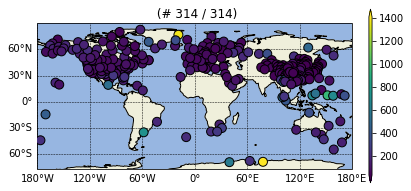

In [15]:
rasotools.plot.map.costfunction(test.location_longitude, test.location_latitude, test.station_name)